**2D Convolutional Neural Network + Longest Short Term Memory (LSTM) Ensemble Classifier**

Data Import & Prepearation of Images in to pass it into a Two Dimensional Convolution Network

In [2]:
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image as Image1
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, BatchNormalization, Reshape

2023-04-25 20:33:06.168211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
R_path = "dataset/R"
T_path = "dataset/T"

In [3]:
R_imgs = os.listdir(R_path)
T_imgs = os.listdir(T_path)

In [4]:
num_R_imgs = len(R_imgs)
print(num_R_imgs)

num_T_imgs = len(T_imgs)
print(num_T_imgs)

1100
400


Sample Input Iamge

In [5]:
sample_img_path = "dataset/R/heatmap_10050.png"
sample_img = Image.open(sample_img_path)

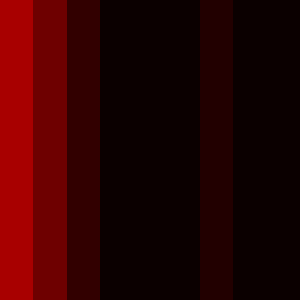

In [6]:
Image1(filename=sample_img_path)

In [7]:
width, height = sample_img.size
print('Image size: {} x {}'.format(width, height))

Image size: 300 x 300


In [8]:
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'
train_dir_R = 'dataset/train/R'
validation_dir_R = 'dataset/validation/R'
train_dir_T = 'dataset/train/T'
validation_dir_T = 'dataset/validation/T'
validation_split = 0.2

In [20]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(train_dir_R, exist_ok=True)
os.makedirs(validation_dir_R, exist_ok=True)
os.makedirs(train_dir_T, exist_ok=True)
os.makedirs(validation_dir_T, exist_ok=True)

In [9]:
num_validation_R = int(num_R_imgs * validation_split)
print(num_validation_R)

220


In [22]:
random.shuffle(R_imgs)
for i, image_name in enumerate(R_imgs):
    if i < num_validation_R:
        shutil.copy(os.path.join(R_path, image_name), os.path.join(validation_dir, "R", image_name))
    else:
        shutil.copy(os.path.join(R_path, image_name), os.path.join(train_dir, "R", image_name))

In [10]:
num_validation_T = int(num_T_imgs * validation_split)
print(num_validation_T)

80


In [24]:
random.shuffle(T_imgs)
for i, image_name in enumerate(T_imgs):
    if i < num_validation_T:
        shutil.copy(os.path.join(T_path, image_name), os.path.join(validation_dir, "T", image_name))
    else:
        shutil.copy(os.path.join(T_path, image_name), os.path.join(train_dir, "T", image_name))

Image Data Preporcessing

In [3]:
img_size = (224, 224)
batch_size = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1211 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 300 images belonging to 2 classes.


Neural Network Design and Compilation

In [11]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((-1, 128))
    # Dense(128, activation='relu'),
    # Dense(2, activation='softmax')
])

2023-04-25 20:34:02.355430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
lstm_model = Sequential()
lstm_model.add(LSTM(128))
lstm_model.add(Dense(2, activation='softmax'))

In [13]:
model = Sequential()
model.add(cnn_model)
model.add(lstm_model)

Network Model Summary

In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [16]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 338, 128)          56320     
                                                                 
 sequential_1 (Sequential)   (None, 2)                 131842    
                                                                 
Total params: 188,162
Trainable params: 188,162
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Network Training

In [48]:
history = model.fit(train_generator,
          epochs=20,
          validation_data=val_generator)

Epoch 1/20
38/38 [==============================] - 22s 563ms/step - loss: 0.3609 - accuracy: 0.8300 - val_loss: 0.1718 - val_accuracy: 0.9333
Epoch 2/20
38/38 [==============================] - 22s 560ms/step - loss: 0.1952 - accuracy: 0.9208 - val_loss: 0.2330 - val_accuracy: 0.9100
Epoch 3/20
38/38 [==============================] - 22s 561ms/step - loss: 0.1703 - accuracy: 0.9408 - val_loss: 0.2395 - val_accuracy: 0.9267
Epoch 4/20
38/38 [==============================] - 21s 541ms/step - loss: 0.1550 - accuracy: 0.9308 - val_loss: 0.2897 - val_accuracy: 0.9167
Epoch 5/20
38/38 [==============================] - 22s 568ms/step - loss: 0.1686 - accuracy: 0.9342 - val_loss: 0.2183 - val_accuracy: 0.9267
Epoch 6/20
38/38 [==============================] - 21s 546ms/step - loss: 0.1593 - accuracy: 0.9433 - val_loss: 0.1301 - val_accuracy: 0.9600
Epoch 7/20
38/38 [==============================] - 22s 560ms/step - loss: 0.1914 - accuracy: 0.9133 - val_loss: 0.1249 - val_accuracy: 0.9700

Results

In [69]:
loss, accuracy = model.evaluate(val_generator)
print("Validation Accuracy: " + str(accuracy))
print("Validation Loss: " + str(loss))

10/10 [==============================] - 1s 134ms/step - loss: 0.1227 - accuracy: 0.9633
Validation Accuracy: 0.9633333086967468
Validation Loss: 0.12271294742822647


In [58]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)

y_pred = np.argmax(y_pred, axis=1)

10/10 [==============================] - 1s 132ms/step


In [50]:
print(history.history)

{'loss': [0.3608938753604889, 0.19515743851661682, 0.1703014373779297, 0.15498213469982147, 0.16861175000667572, 0.15927813947200775, 0.19139976799488068, 0.15313096344470978, 0.12295560538768768, 0.14234349131584167, 0.1567363739013672, 0.12902423739433289, 0.11506114900112152, 0.1319696605205536, 0.12087386101484299, 0.1072520837187767, 0.09727870672941208, 0.12234365195035934, 0.10643458366394043, 0.09835471957921982], 'accuracy': [0.8299999833106995, 0.9208333492279053, 0.940833330154419, 0.9308333396911621, 0.934166669845581, 0.9433333277702332, 0.9133333563804626, 0.9416666626930237, 0.9583333134651184, 0.9441666603088379, 0.9483333230018616, 0.9491666555404663, 0.949999988079071, 0.9516666531562805, 0.9541666507720947, 0.9541666507720947, 0.9691666960716248, 0.949999988079071, 0.9608333110809326, 0.9616666436195374], 'val_loss': [0.17175251245498657, 0.2330022156238556, 0.2394600361585617, 0.28969454765319824, 0.21833977103233337, 0.1301264613866806, 0.12485487759113312, 0.12817

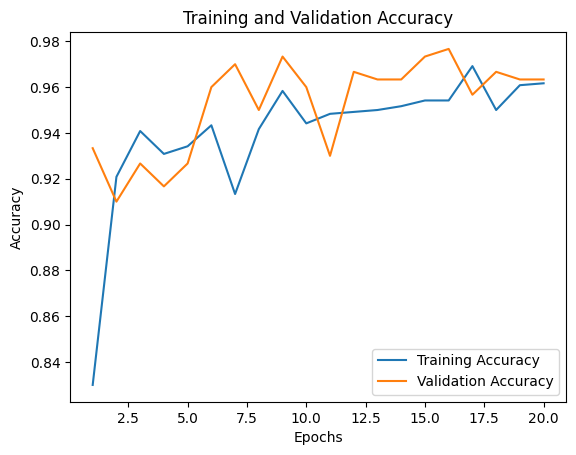

In [51]:
num_epochs = range(1, 21) 
plt.plot(num_epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(num_epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

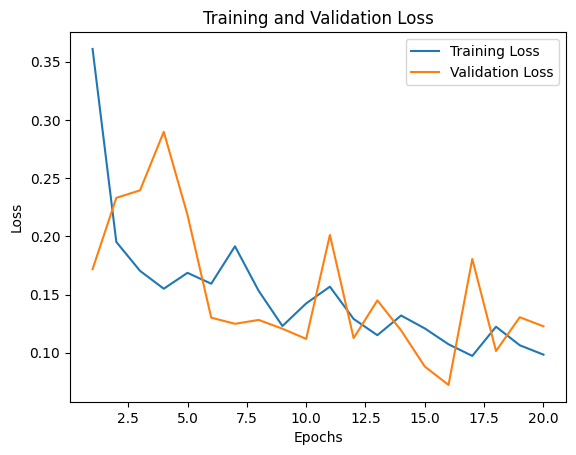

In [52]:
num_epochs = range(1, 21) 
plt.plot(num_epochs, history.history['loss'], label='Training Loss')
plt.plot(num_epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[168  52]
 [ 63  17]]


In [61]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_norm)

Normalized Confusion Matrix:
[[0.76363636 0.23636364]
 [0.7875     0.2125    ]]


In [62]:
TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

In [63]:
print("Sensitivity: {:.2f}".format(sensitivity))
print("Specificity: {:.2f}".format(specificity))

Sensitivity: 0.76
Specificity: 0.21


In [64]:
accuracy = (cm[0, 0] + cm[1, 1]) / sum(sum(cm))
precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))

Accuracy: 0.62
Precision: 0.73


In [70]:
from sklearn.metrics import f1_score

In [71]:
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

F1 score: 0.22818791946308725
